In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools

#file = r'/Users/rshara01/WORK/GUI/devicescan_11152024.csv'
#file = r'/Users/rshara01/WORK/GUI/devicescan_ldpadj_11182024.csv'
file = r'/Users/rshara01/Desktop/Beam Study 30OCT2024/devicescan_l0padj_0_360.csv'
cav = ['L:L0PADJ','L:C0PHAS']
bpm_list = list(itertools.product(*[range(0,8,1),range(1,5,1)]))
#bpm = ['L:D%d%dBF'%(i,j) for i,j in bpm_list if '%d%d'%(i,j) not in ['01','04','14','24']]
bpm = ['L:D%d%dBF'%(i,j) for i,j in bpm_list if (i,j) not in [(0,1),(0,4),(1,4),(2,4)]]
dataset = pd.read_csv(file)
dataset.columns = dataset.columns.str.replace("[(R)]", "",regex=True)



In [13]:

dataset = dataset[cav+bpm].iloc[1:-2,:] #bad last reading
dataset.reset_index(drop=True,inplace=True)
dataset.dropna(inplace=True)

dfbpms = [np.unwrap(dataset[b.strip()]) for b in bpm[:5]]
dfbpms = [df - dfbpms[0] for df in dfbpms]


In [14]:
amplitude = []
period    = 0
a = 0
for df in dfbpms[1:]: 
    amplitude.append((df.max() - df.min())/2)
    if amplitude[-1] > a:
        a = amplitude[-1]
        period = np.absolute(dataset['L:L0PADJ'][np.argmax(dfbpms[-1])] - dataset['L:L0PADJ'][np.argmin(dfbpms[-1])])
print(amplitude,period)

[10.29693603515625, 29.79766845703125, 43.540690922586975, 53.60054272016416] 169.99282836914062


In [15]:

#fitting
from scipy.optimize import curve_fit
def sin_fn(x, freq, amplitude, phase, offset):
  return np.sin(x*freq + phase) * amplitude + offset

fits = []

for i in range(1,len(dfbpms)):

    #p0 = [np.pi/period, amplitude[i], 0., dfbpms[i].max()] #frequency,amplitude,phase,offset
    p0 = [np.pi/period, amplitude[i-1], 0., 0.]
    fit = curve_fit(sin_fn, dataset['L:L0PADJ'] - dataset['L:L0PADJ'].min(), 
                    dfbpms[i] - dfbpms[i].max() + amplitude[i-1], p0 = p0)    
    #fit = curve_fit(sin_fn, dataset['L:LDPADJ'] - dataset['L:LDPADJ'].min(), dfbpms[i] + amplitude[i],p0=p0)
    fits.append(fit)
    fitted_sin = sin_fn(dataset['L:L0PADJ'] - dataset['L:L0PADJ'].min(), fit[0][0], fit[0][1], fit[0][2], fit[0][3])

    fit_min=np.argmin(fitted_sin)
    fit_max=np.argmax(fitted_sin)
    print(bpm[i],'90 deg at: ',dataset['L:L0PADJ'].iloc[int(fit_min - np.abs(fit_max-fit_min)/2.)])
    

L:D03BF 90 deg at:  182.00225830078125
L:D11BF 90 deg at:  181.00662231445312
L:D12BF 90 deg at:  180.00411987304688
L:D13BF 90 deg at:  179.00161743164062


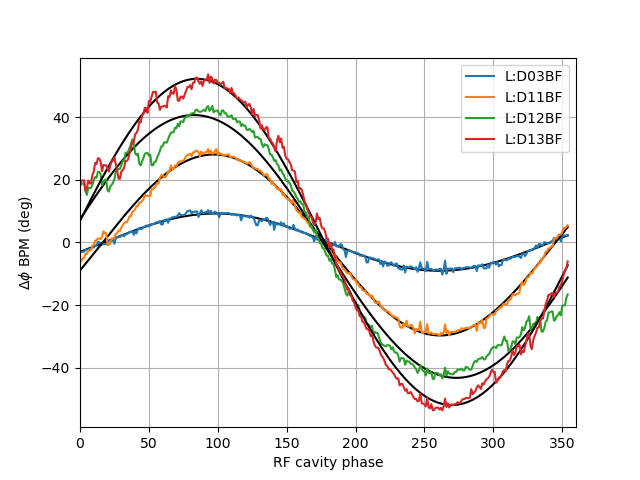

In [16]:

%matplotlib widget
plt.cla()
plt.figure(1)
for i in range(1,len(dfbpms)):
    fitted_sin = sin_fn(dataset['L:L0PADJ'] - dataset['L:L0PADJ'].min(), fits[i-1][0][0], fits[i-1][0][1],
                        fits[i-1][0][2], fits[i-1][0][3])
    plt.plot(dataset['L:L0PADJ'] - dataset['L:L0PADJ'].min(), fitted_sin, color = "black")
    plt.plot(dataset['L:L0PADJ'] - dataset['L:L0PADJ'].min(), dfbpms[i] - dfbpms[i].max() + amplitude[i-1],label=bpm[i])
plt.xlabel("RF cavity phase")
#plt.title("BPM Phase vs RF Phase")
plt.ylabel(r'$\Delta\phi$ BPM (deg)')
plt.grid()
plt.legend()
plt.xlim(0, 360)
plt.show()

[  1.11558599 -13.60904381]


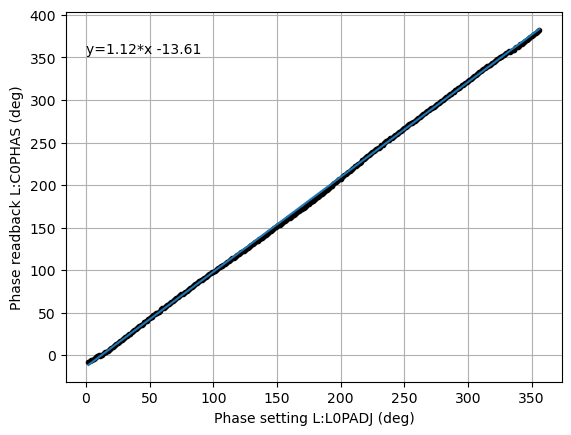

In [28]:
%matplotlib inline
plt.cla()
coef= np.polyfit(dataset['L:L0PADJ'], np.unwrap(dataset['L:C0PHAS'])-360., 1)
poly1d_fn = np.poly1d(coef)

print(coef)

plt.plot(dataset['L:L0PADJ'],np.unwrap(dataset['L:C0PHAS'])-360,'k.')
plt.plot(dataset['L:L0PADJ'],poly1d_fn(dataset['L:L0PADJ']))
plt.grid()
plt.xlabel('Phase setting L:L0PADJ (deg)')
plt.ylabel('Phase readback L:C0PHAS (deg)')
plt.text(0.,355,'y=%.2f*x %.2f'%(coef[0],coef[1]))
plt.show()